In [ ]:
import sys, os, types, math, pathlib, warnings
from types import SimpleNamespace

import sys
path_to_pip_installs = "/tmp/test_env"
if path_to_pip_installs not in sys.path:
    sys.path.insert(1, path_to_pip_installs)

import torch
import torch.nn.functional as F
from torchvision import transforms, utils
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import CenterCrop
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

from dataset import CreateDatasetSynthesis

from backbones.ncsnpp_generator_adagn import NCSNpp

device = "cpu"

W0916 10:37:43.147000 218187 torch/utils/cpp_extension.py:118] No CUDA runtime is found, using CUDA_HOME='/home/students/studweilc1/.conda/envs/cornelius_new'
W0916 10:37:43.385000 218187 torch/utils/cpp_extension.py:2425] TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
W0916 10:37:43.385000 218187 torch/utils/cpp_extension.py:2425] If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'] to specific architectures.
W0916 10:37:43.445000 218187 torch/utils/cpp_extension.py:2425] TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
W0916 10:37:43.445000 218187 torch/utils/cpp_extension.py:2425] If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'] to specific architectures.


module_path = /mnt/ceph/vol_02_home_students/studweilc1/SynDiff/utils/op


In [2]:
to_range_0_1 = lambda x: (x + 1.) / 2.

def psnr_torch(img1, img2, data_range=1.0):
    # conbert torch to numpy and call
    img1_np = to_range_0_1(img1).detach().numpy()
    img2_np = to_range_0_1(img2).detach().numpy()
    return psnr(img1_np, img2_np, data_range=img1_np.max())

## Load Data

padding in x-y with:0-0
padding in x-y with:0-0


/tmp/test_env/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


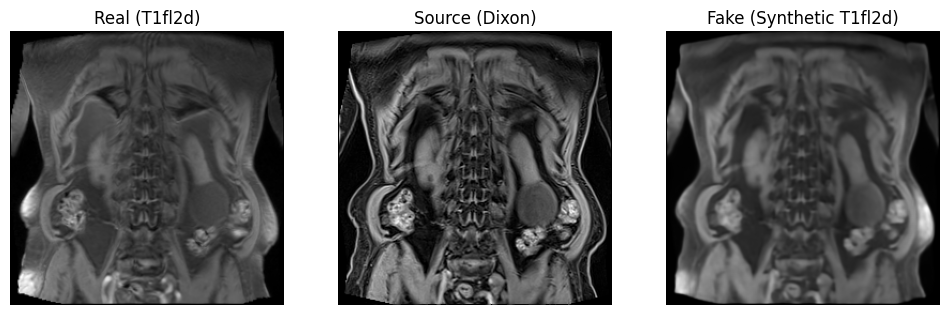

In [ ]:
# ---- your dataset code (from your message) ----
from dataset import CreateDatasetSynthesis

input_path = "data/my_data_group_registered"
contrast1 = "T1_mapping_fl2d"
contrast2 = "DIXON_T1_mapping_fl2d"

dataset_val = CreateDatasetSynthesis(
    phase="test",
    input_path=input_path,
    contrast1=contrast1,
    contrast2=contrast2
)

val_sampler = torch.utils.data.distributed.DistributedSampler(
    dataset_val,
    num_replicas=1,
    rank=0   # keep this an int
)

data_loader_val = torch.utils.data.DataLoader(
    dataset_val,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    sampler=val_sampler,
    drop_last=True
)

# ---- import the exact functions/classes used in training ----
from train import Posterior_Coefficients, get_time_schedule, sample_from_model
from backbones.ncsnpp_generator_adagn import NCSNpp

# ---- minimal args namespace matching training defaults the model expects ----
from types import SimpleNamespace
args = SimpleNamespace(
    # diffusion / sampling
    num_timesteps=4,
    nz=100,

    # NCSNpp architecture args (use the same values you trained with;
    # these mirror train.py defaults)
    image_size=256,
    num_channels=2,           # important: 2 channels (x_t + source)
    num_channels_dae=64,
    n_mlp=3,
    ch_mult=[1, 1, 2, 2, 4, 4],             # NCSNpp will handle default inside if implemented that way in your codebase
    num_res_blocks=2,
    attn_resolutions=(16,),
    dropout=0.,
    resamp_with_conv=True,
    conditional=True,
    fir=True,
    fir_kernel=[1,3,3,1],
    skip_rescale=True,
    resblock_type='biggan',
    progressive='none',
    progressive_input='residual',
    progressive_combine='sum',
    embedding_type='positional',
    fourier_scale=16.,
    not_use_tanh=False,
    z_emb_dim=256,
    t_emb_dim=256,
    beta_min=0.02,
    ngf=64,
    r1_gamma=5,
    num_process_per_node=1,
    lazy_reg=10,
    beta_max=20,
    use_geometric=False,
    centered=True,
)

# ---- build generators (one per direction) and load checkpoints ----
gen1 = NCSNpp(args).to(device).eval()
gen2 = NCSNpp(args).to(device).eval()

def load_stripping_module(model, ckpt_path):
    """Load a state_dict possibly saved from DDP ('module.' prefix)."""
    sd = torch.load(ckpt_path, map_location=device)
    if any(k.startswith("module.") for k in sd.keys()):
        sd = {k.replace("module.", "", 1): v for k, v in sd.items()}
    model.load_state_dict(sd, strict=True)

# TODO: set these to your saved files
ckpt_1 = "results/my_results_group_non_diffusive_registered/exp_syndiff_T1fl2d/gen_diffusive_1_10.pth"
ckpt_2 = "results/my_results_group_non_diffusive_registered/exp_syndiff_T1fl2d/gen_diffusive_2_10.pth"
load_stripping_module(gen1, ckpt_1)
load_stripping_module(gen2, ckpt_2)

# ---- build coeffs and time schedule exactly like training ----
pos_coeff = Posterior_Coefficients(args, device)
T = get_time_schedule(args, device)
to_range_0_1 = lambda x: (x + 1.) / 2.

# ---- evaluate PSNR the same way as training ----
psnrs_dir1 = []  # "Class 1" in training printout
psnrs_dir2 = []  # "Class 2" in training printout
ssim_dir1 = []
ssim_dir2 = []

# Direction 1: (x_val, y_val) => use gen1
with torch.no_grad():
    for i,(x_val, y_val) in enumerate(data_loader_val):
        real_data = x_val.to(device, non_blocking=True)    # contrast1 (target)
        source_data = y_val.to(device, non_blocking=True)  # contrast2 (source)

        # concatenate noise + source (exactly like training)
        x1_t = torch.cat((torch.randn_like(real_data), source_data), dim=1)

        # sample from model (same call / args as training)
        fake = sample_from_model(pos_coeff, gen1, args.num_timesteps, x1_t, T, args)

        # map to [0,1] *exactly as training does* then move to numpy
        fake_np = to_range_0_1(fake).cpu().numpy()
        real_np = to_range_0_1(real_data).cpu().numpy()

        # L1 (optional, in case you want to check)
        # l1 = np.abs(fake_np - real_np).mean()

        # PSNR exactly as in training (data_range=real_data.max())
        # Note: training uses the batch array directly; we keep it identical
        p = psnr(real_np, fake_np, data_range=real_np.max())
        psnrs_dir1.append(p)

        s = ssim(fake_np[0,0,:,:], real_np[0,0,:,:], data_range=real_np.max())
        ssim_dir1.append(s)

        if i % 20 == 0:
            # show real, source and fae´ke image next to each other
            fig, ax = plt.subplots(1,3, figsize=(12,6))
            ax[0].imshow(to_range_0_1(real_data[0,0]).cpu(), cmap="gray")
            ax[0].set_title("Real (T1fl2d)")
            ax[1].imshow(to_range_0_1(source_data[0,0]).cpu(), cmap="gray")
            ax[1].set_title("Source (Dixon)")
            ax[2].imshow(to_range_0_1(fake[0,0]).cpu(), cmap="gray")
            ax[2].set_title("Fake (Synthetic T1fl2d)")
            for a in ax:
                a.axis('off')
            plt.show()

# Direction 2: (y_val, x_val) => use gen2 (note the swap in the loader order)
with torch.no_grad():
    for i,(y_val, x_val) in enumerate(data_loader_val):
            
        real_data = x_val.to(device, non_blocking=True)    # contrast2->contrast1 direction target
        source_data = y_val.to(device, non_blocking=True)  # source

        x1_t = torch.cat((torch.randn_like(real_data), source_data), dim=1)
        fake = sample_from_model(pos_coeff, gen2, args.num_timesteps, x1_t, T, args)

        fake_np = to_range_0_1(fake).cpu().numpy()
        real_np = to_range_0_1(real_data).cpu().numpy()
        p = psnr(real_np, fake_np, data_range=real_np.max())
        psnrs_dir2.append(p)

        s = ssim(fake_np[0,0,:,:], real_np[0,0,:,:], data_range=real_np.max())
        ssim_dir2.append(s)

        if i % 20 == 0:
            # show real, source and fae´ke image next to each other
            fig, ax = plt.subplots(1,3, figsize=(12,6))
            ax[0].imshow(to_range_0_1(real_data[0,0]).cpu(), cmap="gray")
            ax[0].set_title("Real (Dixon)")
            ax[1].imshow(to_range_0_1(source_data[0,0]).cpu(), cmap="gray")
            ax[1].set_title("Source (Tf2ld)")
            ax[2].imshow(to_range_0_1(fake[0,0]).cpu(), cmap="gray")
            ax[2].set_title("Fake (Synthetic Dixon)")
            for a in ax:
                a.axis('off')
            plt.show()


print("Validation PSNR Values:")
print("Class 1:")
print(np.nanmean(psnrs_dir1))
print("Class 2:")
print(np.nanmean(psnrs_dir2))
print("Class 1 SSIM:")
print(np.nanmean(ssim_dir1))
print("Class 2 SSIM:")
print(np.nanmean(ssim_dir2))


## Complete code

#### Function

In [37]:
def calculate_values(input_path, contrast1, contrast2, ckpt_1, ckpt_2, plot, split="test", max_samples=None):

    #input_path = "data/my_data_group_registered"
    #contrast1 = "T1_mapping_fl2d"
    #contrast2 = "DIXON_T1_mapping_fl2d"

    dataset_val = CreateDatasetSynthesis(
        phase=split,
        input_path=input_path,
        contrast1=contrast1,
        contrast2=contrast2
    )

    val_sampler = torch.utils.data.distributed.DistributedSampler(
        dataset_val,
        num_replicas=1,
        rank=0   # keep this an int
    )

    data_loader_val = torch.utils.data.DataLoader(
        dataset_val,
        batch_size=1,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        sampler=val_sampler,
        drop_last=True
    )

    # ---- import the exact functions/classes used in training ----
    from train import Posterior_Coefficients, get_time_schedule, sample_from_model
    from backbones.ncsnpp_generator_adagn import NCSNpp

    # ---- minimal args namespace matching training defaults the model expects ----
    from types import SimpleNamespace
    args = SimpleNamespace(
        # diffusion / sampling
        num_timesteps=4,
        nz=100,

        # NCSNpp architecture args (use the same values you trained with;
        # these mirror train.py defaults)
        image_size=256,
        num_channels=2,           # important: 2 channels (x_t + source)
        num_channels_dae=64,
        n_mlp=3,
        ch_mult=[1, 1, 2, 2, 4, 4],             # NCSNpp will handle default inside if implemented that way in your codebase
        num_res_blocks=2,
        attn_resolutions=(16,),
        dropout=0.,
        resamp_with_conv=True,
        conditional=True,
        fir=True,
        fir_kernel=[1,3,3,1],
        skip_rescale=True,
        resblock_type='biggan',
        progressive='none',
        progressive_input='residual',
        progressive_combine='sum',
        embedding_type='positional',
        fourier_scale=16.,
        not_use_tanh=False,
        z_emb_dim=256,
        t_emb_dim=256,
        beta_min=0.02,
        ngf=64,
        r1_gamma=5,
        num_process_per_node=1,
        lazy_reg=10,
        beta_max=20,
        use_geometric=False,
        centered=True,
    )

    # ---- build generators (one per direction) and load checkpoints ----
    gen1 = NCSNpp(args).to(device).eval()
    gen2 = NCSNpp(args).to(device).eval()

    def load_stripping_module(model, ckpt_path):
        """Load a state_dict possibly saved from DDP ('module.' prefix)."""
        sd = torch.load(ckpt_path, map_location=device)
        if any(k.startswith("module.") for k in sd.keys()):
            sd = {k.replace("module.", "", 1): v for k, v in sd.items()}
        model.load_state_dict(sd, strict=True)

    # TODO: set these to your saved files
    #ckpt_1 = "results/my_results_group_non_diffusive_registered/exp_syndiff_T1fl2d/gen_diffusive_1_10.pth"
    #ckpt_2 = "results/my_results_group_non_diffusive_registered/exp_syndiff_T1fl2d/gen_diffusive_2_10.pth"
    load_stripping_module(gen1, ckpt_1)
    load_stripping_module(gen2, ckpt_2)

    # ---- build coeffs and time schedule exactly like training ----
    pos_coeff = Posterior_Coefficients(args, device)
    T = get_time_schedule(args, device)
    to_range_0_1 = lambda x: (x + 1.) / 2.

    # ---- evaluate PSNR the same way as training ----
    psnrs_dir1 = []  # "Class 1" in training printout
    psnrs_dir2 = []  # "Class 2" in training printout
    ssim_dir1 = []
    ssim_dir2 = []

    # Direction 1: (x_val, y_val) => use gen1
    with torch.no_grad():
        for i,(x_val, y_val) in enumerate(data_loader_val):
            real_data = x_val.to(device, non_blocking=True)    # contrast1 (target)
            source_data = y_val.to(device, non_blocking=True)  # contrast2 (source)

            # concatenate noise + source (exactly like training)
            x1_t = torch.cat((torch.randn_like(real_data), source_data), dim=1)

            # sample from model (same call / args as training)
            fake = sample_from_model(pos_coeff, gen1, args.num_timesteps, x1_t, T, args)

            # map to [0,1] *exactly as training does* then move to numpy
            fake_np = to_range_0_1(fake).cpu().numpy()
            real_np = to_range_0_1(real_data).cpu().numpy()

            # L1 (optional, in case you want to check)
            # l1 = np.abs(fake_np - real_np).mean()

            # PSNR exactly as in training (data_range=real_data.max())
            # Note: training uses the batch array directly; we keep it identical
            p = psnr(real_np, fake_np, data_range=real_np.max())
            psnrs_dir1.append(p)

            s = ssim(fake_np[0,0,:,:], real_np[0,0,:,:], data_range=real_np.max())
            ssim_dir1.append(s)

            if i % 20 == 0 and plot:
                # show real, source and fae´ke image next to each other
                fig, ax = plt.subplots(1,3, figsize=(12,6))
                ax[0].imshow(to_range_0_1(real_data[0,0]).cpu(), cmap="gray")
                ax[0].set_title("Real (T1fl2d)")
                ax[1].imshow(to_range_0_1(source_data[0,0]).cpu(), cmap="gray")
                ax[1].set_title("Source (Dixon)")
                ax[2].imshow(to_range_0_1(fake[0,0]).cpu(), cmap="gray")
                ax[2].set_title("Fake (Synthetic T1fl2d)")
                for a in ax:
                    a.axis('off')
                plt.show()

            if max_samples is not None and i >= max_samples:
                break

    # Direction 2: (y_val, x_val) => use gen2 (note the swap in the loader order)
    with torch.no_grad():
        for i,(y_val, x_val) in enumerate(data_loader_val):
                
            real_data = x_val.to(device, non_blocking=True)    # contrast2->contrast1 direction target
            source_data = y_val.to(device, non_blocking=True)  # source

            x1_t = torch.cat((torch.randn_like(real_data), source_data), dim=1)
            fake = sample_from_model(pos_coeff, gen2, args.num_timesteps, x1_t, T, args)

            fake_np = to_range_0_1(fake).cpu().numpy()
            real_np = to_range_0_1(real_data).cpu().numpy()
            p = psnr(real_np, fake_np, data_range=real_np.max())
            psnrs_dir2.append(p)

            s = ssim(fake_np[0,0,:,:], real_np[0,0,:,:], data_range=real_np.max())
            ssim_dir2.append(s)

            if i % 20 == 0 and plot:
                # show real, source and fae´ke image next to each other
                fig, ax = plt.subplots(1,3, figsize=(12,6))
                ax[0].imshow(to_range_0_1(real_data[0,0]).cpu(), cmap="gray")
                ax[0].set_title("Real (Dixon)")
                ax[1].imshow(to_range_0_1(source_data[0,0]).cpu(), cmap="gray")
                ax[1].set_title("Source (Tf2ld)")
                ax[2].imshow(to_range_0_1(fake[0,0]).cpu(), cmap="gray")
                ax[2].set_title("Fake (Synthetic Dixon)")
                for a in ax:
                    a.axis('off')
                plt.show()
            
            if max_samples is not None and i >= max_samples:
                break


    print("Validation PSNR Values:")
    print("Class 1:")
    print(np.nanmean(psnrs_dir1))
    print("Class 2:")
    print(np.nanmean(psnrs_dir2))
    print("Class 1 SSIM:")
    print(np.nanmean(ssim_dir1))
    print("Class 2 SSIM:")
    print(np.nanmean(ssim_dir2))
    return np.nanmean(psnrs_dir1), np.nanmean(psnrs_dir2), np.nanmean(ssim_dir1), np.nanmean(ssim_dir2)


#### Execution

In [38]:
input_path = "data/my_data_group_registered"
contrast1 = "T1_mapping_fl2d"
contrast2 = "DIXON_T1_mapping_fl2d"
ckpt_1 = "results/my_results_group_non_diffusive_registered/exp_syndiff_T1fl2d/gen_diffusive_1_10.pth"
ckpt_2 = "results/my_results_group_non_diffusive_registered/exp_syndiff_T1fl2d/gen_diffusive_2_10.pth"

psnr1, psnr2, ssim1, ssim2 = calculate_values(input_path, contrast1, contrast2, ckpt_1, ckpt_2, plot=False, split="test", max_samples=None)

padding in x-y with:0-0
padding in x-y with:0-0


/tmp/test_env/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation PSNR Values:
Class 1:
24.668793783010514
Class 2:
22.039985751168828
Class 1 SSIM:
0.7873161323089943
Class 2 SSIM:
0.6702373573607444


In [42]:
# quick run on train set
input_path = "data/my_data_group_registered"
contrast1 = "T1_mapping_fl2d"
contrast2 = "DIXON_T1_mapping_fl2d"
ckpt_1 = "results/my_results_group_non_diffusive_registered/exp_syndiff_T1fl2d/gen_diffusive_1_10.pth"
ckpt_2 = "results/my_results_group_non_diffusive_registered/exp_syndiff_T1fl2d/gen_diffusive_2_10.pth"

psnr1, psnr2, ssim1, ssim2 = calculate_values(input_path, contrast1, contrast2, ckpt_1, ckpt_2, plot=False, split="train", max_samples=30)

padding in x-y with:0-0
padding in x-y with:0-0
Validation PSNR Values:
Class 1:
26.787928781271415
Class 2:
24.11291557847765
Class 1 SSIM:
0.8219515979514554
Class 2 SSIM:
0.6999825216139277


In [39]:
input_path = "data/my_data_group"
contrast1 = "T1_mapping_fl2d"
contrast2 = "DIXON_T1_mapping_fl2d"
ckpt_1 = "results/my_results_group_unpaired/exp_syndiff_T1fl2d/gen_diffusive_1_30.pth"
ckpt_2 = "results/my_results_group_unpaired/exp_syndiff_T1fl2d/gen_diffusive_2_30.pth"

psnr1, psnr2, ssim1, ssim2 = calculate_values(input_path, contrast1, contrast2, ckpt_1, ckpt_2, plot=False, split="test", max_samples=None)

padding in x-y with:0-0
padding in x-y with:0-0
Validation PSNR Values:
Class 1:
23.441821625722916
Class 2:
20.477509774926645
Class 1 SSIM:
0.7342270522464874
Class 2 SSIM:
0.6352732431634647


In [40]:
input_path = "data/my_data_group"
contrast1 = "T1_mapping_fl2d"
contrast2 = "DIXON_T1_mapping_fl2d"
ckpt_1 = "results/my_results_group/exp_syndiff_T1fl2d3/gen_diffusive_1_40.pth"
ckpt_2 = "results/my_results_group/exp_syndiff_T1fl2d3/gen_diffusive_2_40.pth"

psnr1, psnr2, ssim1, ssim2 = calculate_values(input_path, contrast1, contrast2, ckpt_1, ckpt_2, plot=False, split="test", max_samples=None)

padding in x-y with:0-0
padding in x-y with:0-0
Validation PSNR Values:
Class 1:
22.938918992834783
Class 2:
20.09059653437161
Class 1 SSIM:
0.7144324704229709
Class 2 SSIM:
0.6131006544914276


In [41]:
input_path = "data/my_data_group"
contrast1 = "T1_mapping_fl2d"
contrast2 = "DIXON_T1_mapping_fl2d"
ckpt_1 = "results/my_results_group/exp_syndiff_T1fl2d2/gen_diffusive_1_10.pth"
ckpt_2 = "results/my_results_group/exp_syndiff_T1fl2d2/gen_diffusive_2_10.pth"

psnr1, psnr2, ssim1, ssim2 = calculate_values(input_path, contrast1, contrast2, ckpt_1, ckpt_2, plot=False, split="test", max_samples=None)

padding in x-y with:0-0
padding in x-y with:0-0
Validation PSNR Values:
Class 1:
23.089587037470253
Class 2:
20.29078763821966
Class 1 SSIM:
0.7139534584184334
Class 2 SSIM:
0.6086299011258879


## Compare Cgan results

In [ ]:
path_to_cgan = "/home/students/studweilc1/SynthRegGAN/data/synthetic_cycle_gan/synthetic_data_T1_mapping_fl2d.h5"
path_to_orginal = "/home/students/studweilc1/SynthRegGAN/data/data_DIXON.h5"

from pytorch_dataset import PairedHDF5ContrastDataset

cfg_transform = {
  "eval": [
    {"PerImageMinMaxNormalize": {}}

  ]
}

cfg_transform_group = {
  "eval": [
    {
      "GroupMinMaxNormalize": {
        "stats_path": "/home/students/studweilc1/SynthRegGAN/data/minmax_values.json"
      }
    },

  ]
}

cfg_filters_dixon = {
  "contrast__in": ["DIXON"],
  "non_zero": True,
  "image_dim": 0,
  "image_type": "W",
  #"patient_id": "P_01_A",
  #"z_dim": 16,
  "split":"test",
}

cfg_filters_t1 = {
  "contrast__in": ["T1_mapping_fl2d"],
  "non_zero": True,
  "image_dim": 0,
  "image_type": "s",
  #"patient_id": "P_01_A",
  #"z_dim": 16,
  "split":"test",
}

hdf5_path_dixon = "/home/students/studweilc1/SynthRegGAN/data/data_DIXON.h5"
hdf5_path_t1 = "/home/students/studweilc1/SynthRegGAN/data/data_T1_mapping_fl2d.h5"

paired_dataset = PairedHDF5ContrastDataset(
    hdf5_path_template=path_to_orginal,
    hdf5_path_moving=path_to_cgan,
    filter_template=cfg_filters_dixon,
    filter_moving=cfg_filters_t1,
    transform_template=cfg_transform,
    transform_moving=cfg_transform,
    stage="eval" 
)

/mnt/ceph/vol_02_home_students/studweilc1/SynDiff/pytorch_dataset.py:54: UserWarning: Argument(s) 'always_apply' are not valid for transform BasicTransform
  super().__init__(always_apply=always_apply, p=p)
/mnt/ceph/vol_02_home_students/studweilc1/SynDiff/pytorch_dataset.py:54: UserWarning: Argument(s) 'always_apply' are not valid for transform BasicTransform
  super().__init__(always_apply=always_apply, p=p)


In [63]:


psnr_values = []
ssim_values = []

for i in range(len(paired_dataset)):
    image_template = paired_dataset[i]["image_template"]
    image_moving = paired_dataset[i]["image_moving"]
    image_template = image_template[0].numpy()
    image_moving = image_moving[0].numpy()
    p = psnr(image_template, image_moving, data_range=image_template.max())
    s = ssim(image_template, image_moving, data_range=image_template.max())
    psnr_values.append(p)
    ssim_values.append(s)

print("CGAN PSNR:")
print(np.nanmean(psnr_values))
print("CGAN SSIM:")
print(np.nanmean(ssim_values))

CGAN PSNR:
14.587696375802807
CGAN SSIM:
0.3826013962852313
